In [77]:
from simulation.SimpleModeSimulation import SimpleModeSimulation
import common
import matplotlib.pyplot as plt
import numpy as np

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

mempool_data_during_congestion = common.doPreprocessing(common.get_mempool_dir_during_congestion())
mempool_data_no_congestion = common.doPreprocessing(common.get_mempool_dir_no_congestion())
blocks_data = common.get_blocks_data()
PROBLEMATIC_INTERVALS = common.get_problematic_intervals()

def compute_average_waiting_time_closing_tx(amount_txs, remaining_zombie_channels_distribution):
  initial_txs = amount_txs
  acc = 0
  block = 1
  for r in remaining_zombie_channels_distribution:
    confirmed_txs = (amount_txs - r)
    acc += confirmed_txs * block
    amount_txs -= confirmed_txs
    block += 1
  return acc / initial_txs

Average # of blocks to close a zombie channel with fee = 1-2 sat/vByte in scenario: 8716.205356437053
Average # of blocks to close a zombie channel with fee = 5-6 sat/vByte in scenario: 7937.9262778454095
Average # of blocks to close a zombie channel with fee = 10-12 sat/vByte in scenario: 7558.234589176455
Average # of blocks to close a zombie channel with fee = 20-25 sat/vByte in scenario: 7334.0827180597935
Average # of blocks to close a zombie channel with fee = 50-60 sat/vByte in scenario: 5543.003177815371
Average # of blocks to close a zombie channel with fee = 60-70 sat/vByte in scenario: 3609.6170811528673
Average # of blocks to close a zombie channel with fee = 70-80 sat/vByte in scenario: 2881.9264517557035
Average # of blocks to close a zombie channel with fee = 80-100 sat/vByte in scenario: 1156.9623247063287
Average # of blocks to close a zombie channel with fee = 100-120 sat/vByte in scenario: 530.207854421274
Average # of blocks to close a zombie channel with fee = 200-

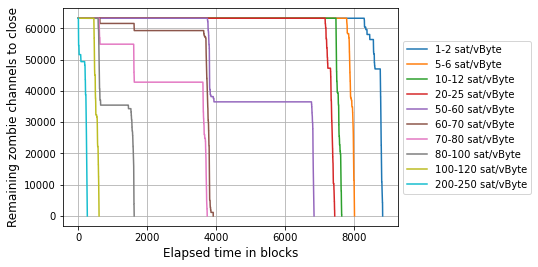

Average # of blocks to close a zombie channel with fee = 1-2 sat/vByte in scenario: 8600.777694638782
Average # of blocks to close a zombie channel with fee = 5-6 sat/vByte in scenario: 7866.869916570017
Average # of blocks to close a zombie channel with fee = 10-12 sat/vByte in scenario: 7498.189457143926
Average # of blocks to close a zombie channel with fee = 20-25 sat/vByte in scenario: 7256.594784690786
Average # of blocks to close a zombie channel with fee = 50-60 sat/vByte in scenario: 3807.1212166560663
Average # of blocks to close a zombie channel with fee = 60-70 sat/vByte in scenario: 3347.9093868083355
Average # of blocks to close a zombie channel with fee = 70-80 sat/vByte in scenario: 1775.5861423921583
Average # of blocks to close a zombie channel with fee = 80-100 sat/vByte in scenario: 603.9057577911632
Average # of blocks to close a zombie channel with fee = 100-120 sat/vByte in scenario: 475.3189419731378
Average # of blocks to close a zombie channel with fee = 200-2

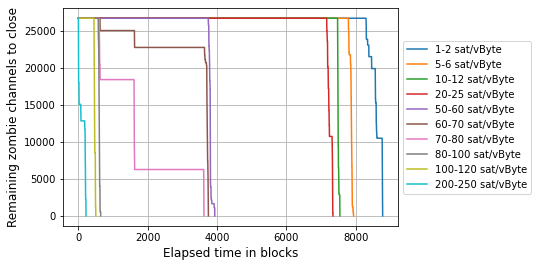

Average # of blocks to close a zombie channel with fee = 1-2 sat/vByte in scenario: 83.6214605302683
Average # of blocks to close a zombie channel with fee = 5-6 sat/vByte in scenario: 61.9981660369006
Average # of blocks to close a zombie channel with fee = 10-12 sat/vByte in scenario: 52.763782390792244
Average # of blocks to close a zombie channel with fee = 20-25 sat/vByte in scenario: 39.394254636290334
Average # of blocks to close a zombie channel with fee = 50-60 sat/vByte in scenario: 38.08575358492356
Average # of blocks to close a zombie channel with fee = 60-70 sat/vByte in scenario: 37.98490142448341
Average # of blocks to close a zombie channel with fee = 70-80 sat/vByte in scenario: 37.908871005992
Average # of blocks to close a zombie channel with fee = 80-100 sat/vByte in scenario: 37.80650108298683
Average # of blocks to close a zombie channel with fee = 100-120 sat/vByte in scenario: 37.46016663768162
Average # of blocks to close a zombie channel with fee = 200-250 sa

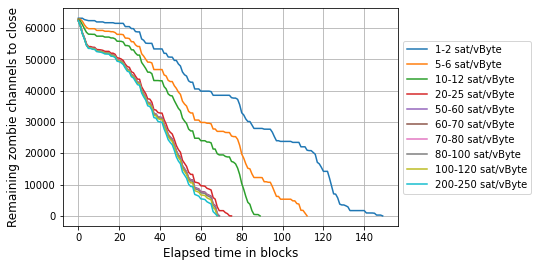

Average # of blocks to close a zombie channel with fee = 1-2 sat/vByte in scenario: 10144.293707
Average # of blocks to close a zombie channel with fee = 5-6 sat/vByte in scenario: 9159.101512
Average # of blocks to close a zombie channel with fee = 10-12 sat/vByte in scenario: 8667.018753
Average # of blocks to close a zombie channel with fee = 20-25 sat/vByte in scenario: 8339.626544
Average # of blocks to close a zombie channel with fee = 50-60 sat/vByte in scenario: 7704.556813
Average # of blocks to close a zombie channel with fee = 60-70 sat/vByte in scenario: 7452.319642
Average # of blocks to close a zombie channel with fee = 70-80 sat/vByte in scenario: 7091.249577
Average # of blocks to close a zombie channel with fee = 80-100 sat/vByte in scenario: 6363.392504
Average # of blocks to close a zombie channel with fee = 100-120 sat/vByte in scenario: 4455.767401
Average # of blocks to close a zombie channel with fee = 200-250 sat/vByte in scenario: 960.880346


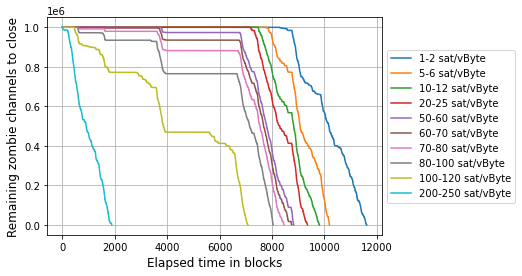

Average # of blocks to close a zombie channel with fee = 1-2 sat/vByte in scenario: 1041.12003
Average # of blocks to close a zombie channel with fee = 5-6 sat/vByte in scenario: 656.679653
Average # of blocks to close a zombie channel with fee = 10-12 sat/vByte in scenario: 471.595734
Average # of blocks to close a zombie channel with fee = 20-25 sat/vByte in scenario: 395.793988
Average # of blocks to close a zombie channel with fee = 50-60 sat/vByte in scenario: 383.850262
Average # of blocks to close a zombie channel with fee = 60-70 sat/vByte in scenario: 382.947215
Average # of blocks to close a zombie channel with fee = 70-80 sat/vByte in scenario: 382.27379
Average # of blocks to close a zombie channel with fee = 80-100 sat/vByte in scenario: 381.107579
Average # of blocks to close a zombie channel with fee = 100-120 sat/vByte in scenario: 377.878543
Average # of blocks to close a zombie channel with fee = 200-250 sat/vByte in scenario: 372.903145


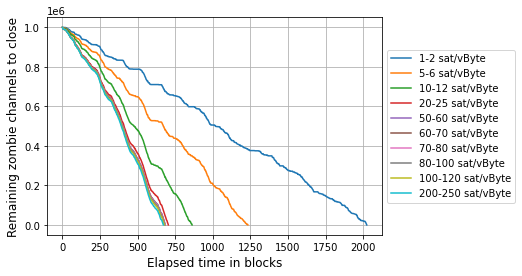

In [81]:
fee_indexes = [1, 5, 9, 13, 17, 18, 19, 20, 21, 25] #, 44]

experiments = []
experiments.append({
    "initial_num_zombie_channels" : common.get_lmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "initial_num_zombie_channels" : common.get_lmc_results()[30]["n_edges"], # k = 30
    "scenario" : 1
})
experiments.append({
    "initial_num_zombie_channels" : common.get_lmc_max_edges(),
    "scenario" : 2
})
experiments.append({
    "initial_num_zombie_channels" : 1000000,
    "scenario" : 1
})
experiments.append({
    "initial_num_zombie_channels" : 1000000,
    "scenario" : 2
})

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True) 
    labels = []

    initial_num_zombie_channels = experiment["initial_num_zombie_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()

    for fee_index in fee_indexes:
        sim = SimpleModeSimulation(
            mempoolData=mempool_data, 
            blocksData=blocks_data, 
            isDynamic=False, 
            firstBlockHeightOfSimulation=first_block_height, 
            problematicIntervals=PROBLEMATIC_INTERVALS, 
            step=-1, 
            beta=-1, 
            remainingTxs=initial_num_zombie_channels, 
            feeIndexInRanges=fee_index)
        needed_blocks, plot_remaining_zombie_channels = sim.run()
        plt.plot(plot_remaining_zombie_channels)
        labels.append(f"{fee_ranges[fee_index]}-{fee_ranges[fee_index + 1]} sat/vByte")
        print(f"Average # of blocks to close a zombie channel with fee = {fee_ranges[fee_index]}-{fee_ranges[fee_index + 1]} sat/vByte in scenario: {compute_average_waiting_time_closing_tx(initial_num_zombie_channels, plot_remaining_zombie_channels)}")

    plt.xlabel('Elapsed time in blocks', fontsize=12) 
    plt.ylabel(f'Remaining zombie channels to close', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

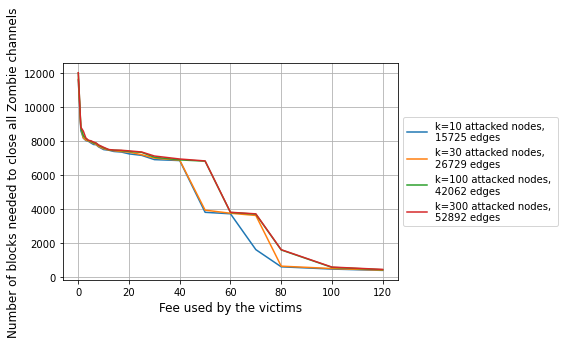

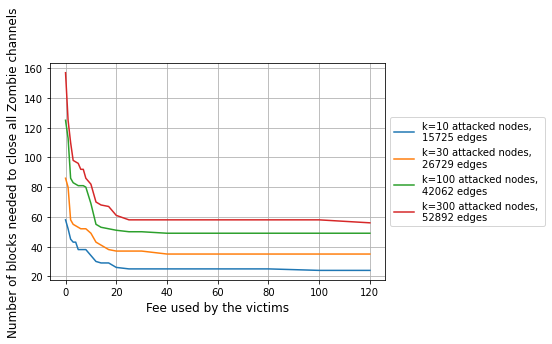

In [51]:
fee_ranges_custom = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120]

k_values = [10, 30, 100, 300]
experiments = []

experiments.append({
    "data" : common.get_lmc_results(), 
    "scenario" : 1
})

experiments.append({
    "data" : common.get_lmc_results(), 
    "scenario" : 2
})


for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True) 
    labels = []
    for k in k_values:
        initial_num_zombie_channels = experiment["data"][k]["n_edges"]
        mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
        first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()
        needed_blocks = [] # number of blocks needed to close all the zombie channels

        i = 0
        while i < len(fee_ranges_custom):
            sim = SimpleModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=False, 
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=-1, 
                beta=-1, 
                remainingTxs=initial_num_zombie_channels, 
                feeIndexInRanges=i)
            blocks_to_close_all_channels, plot_remaining_zombie_channels = sim.run()
            needed_blocks.append(blocks_to_close_all_channels)
            i += 1
            
        plt.plot(fee_ranges_custom, needed_blocks)
        labels.append(f"k={k} attacked nodes, \n{initial_num_zombie_channels} edges")

    plt.xlabel('Fee used by the victims', fontsize=12) 
    plt.ylabel(f'Number of blocks needed to close all Zombie channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Starting experiment...
Simulation with initial fee index = 1 and step = 1.0
Simulation with initial fee index = 1 and step = 2.0
Simulation with initial fee index = 1 and step = 3.0
Simulation with initial fee index = 1 and step = 4.0
Simulation with initial fee index = 1 and step = 5.0
Simulation with initial fee index = 1 and step = 6.0
Simulation with initial fee index = 1 and step = 7.0
Simulation with initial fee index = 1 and step = 8.0
Simulation with initial fee index = 1 and step = 9.0
Simulation with initial fee index = 1 and step = 10.0
Simulation with initial fee index = 1 and step = 11.0
Simulation with initial fee index = 1 and step = 12.0
Simulation with initial fee index = 1 and step = 13.0
Simulation with initial fee index = 1 and step = 14.0
Simulation with initial fee index = 1 and step = 15.0
Simulation with initial fee index = 1 and step = 16.0
Simulation with initial fee index = 1 and step = 17.0
Simulation with initial fee index = 1 and step = 18.0
Simulation wit

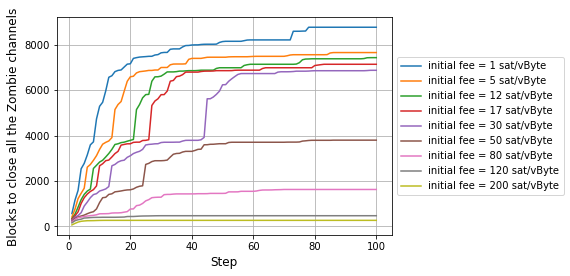

Starting experiment...
Simulation with initial fee index = 1 and step = 1.0
Simulation with initial fee index = 1 and step = 2.0
Simulation with initial fee index = 1 and step = 3.0
Simulation with initial fee index = 1 and step = 4.0
Simulation with initial fee index = 1 and step = 5.0
Simulation with initial fee index = 1 and step = 6.0
Simulation with initial fee index = 1 and step = 7.0
Simulation with initial fee index = 1 and step = 8.0
Simulation with initial fee index = 1 and step = 9.0
Simulation with initial fee index = 1 and step = 10.0
Simulation with initial fee index = 1 and step = 11.0
Simulation with initial fee index = 1 and step = 12.0
Simulation with initial fee index = 1 and step = 13.0
Simulation with initial fee index = 1 and step = 14.0
Simulation with initial fee index = 1 and step = 15.0
Simulation with initial fee index = 1 and step = 16.0
Simulation with initial fee index = 1 and step = 17.0
Simulation with initial fee index = 1 and step = 18.0
Simulation wit

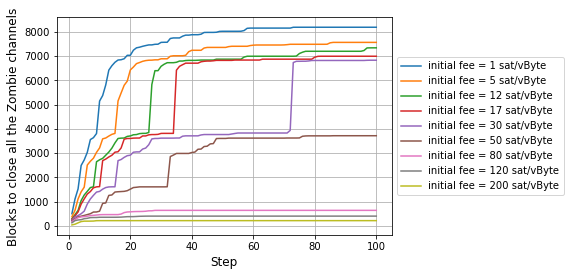

Starting experiment...
Simulation with initial fee index = 1 and step = 1.0
Simulation with initial fee index = 1 and step = 2.0
Simulation with initial fee index = 1 and step = 3.0
Simulation with initial fee index = 1 and step = 4.0
Simulation with initial fee index = 1 and step = 5.0
Simulation with initial fee index = 1 and step = 6.0
Simulation with initial fee index = 1 and step = 7.0
Simulation with initial fee index = 1 and step = 8.0
Simulation with initial fee index = 1 and step = 9.0
Simulation with initial fee index = 1 and step = 10.0
Simulation with initial fee index = 1 and step = 11.0
Simulation with initial fee index = 1 and step = 12.0
Simulation with initial fee index = 1 and step = 13.0
Simulation with initial fee index = 1 and step = 14.0
Simulation with initial fee index = 1 and step = 15.0
Simulation with initial fee index = 1 and step = 16.0
Simulation with initial fee index = 1 and step = 17.0
Simulation with initial fee index = 1 and step = 18.0
Simulation wit

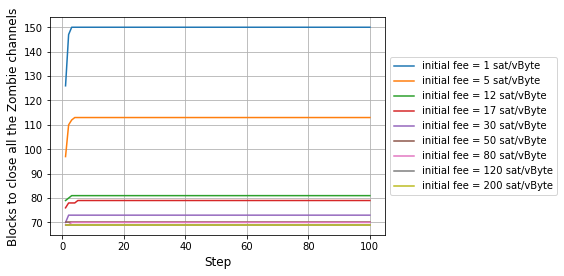

Starting experiment...
Simulation with initial fee index = 1 and step = 1.0
Simulation with initial fee index = 1 and step = 2.0
Simulation with initial fee index = 1 and step = 3.0
Simulation with initial fee index = 1 and step = 4.0
Simulation with initial fee index = 1 and step = 5.0
Simulation with initial fee index = 1 and step = 6.0
Simulation with initial fee index = 1 and step = 7.0
Simulation with initial fee index = 1 and step = 8.0
Simulation with initial fee index = 1 and step = 9.0
Simulation with initial fee index = 1 and step = 10.0
Simulation with initial fee index = 1 and step = 11.0
Simulation with initial fee index = 1 and step = 12.0
Simulation with initial fee index = 1 and step = 13.0
Simulation with initial fee index = 1 and step = 14.0
Simulation with initial fee index = 1 and step = 15.0
Simulation with initial fee index = 1 and step = 16.0
Simulation with initial fee index = 1 and step = 17.0
Simulation with initial fee index = 1 and step = 18.0
Simulation wit

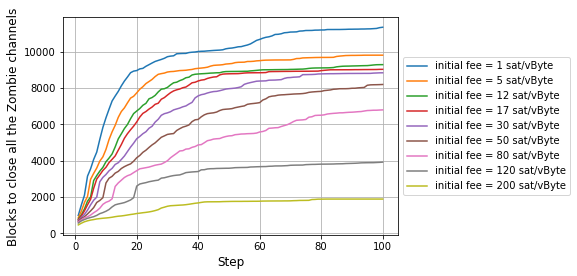

Starting experiment...
Simulation with initial fee index = 1 and step = 1.0
Simulation with initial fee index = 1 and step = 2.0
Simulation with initial fee index = 1 and step = 3.0
Simulation with initial fee index = 1 and step = 4.0
Simulation with initial fee index = 1 and step = 5.0
Simulation with initial fee index = 1 and step = 6.0
Simulation with initial fee index = 1 and step = 7.0
Simulation with initial fee index = 1 and step = 8.0
Simulation with initial fee index = 1 and step = 9.0
Simulation with initial fee index = 1 and step = 10.0
Simulation with initial fee index = 1 and step = 11.0
Simulation with initial fee index = 1 and step = 12.0
Simulation with initial fee index = 1 and step = 13.0
Simulation with initial fee index = 1 and step = 14.0
Simulation with initial fee index = 1 and step = 15.0
Simulation with initial fee index = 1 and step = 16.0
Simulation with initial fee index = 1 and step = 17.0
Simulation with initial fee index = 1 and step = 18.0
Simulation wit

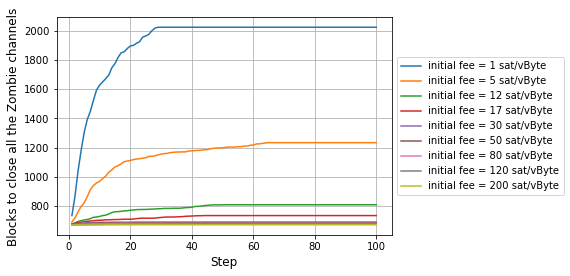

In [82]:
# Dynamic Case
# beta: factor of growth of the fee (new_fee = alpha * beta)
# step: number of blocks after which the fee is increased

fee_ranges_custom = [1, 5, 12, 17, 30, 50, 80, 120, 200]

experiments = []
experiments.append({
    "initial_num_zombie_channels" : common.get_lmc_max_edges(), 
    "scenario" : 1
})
experiments.append({
    "initial_num_zombie_channels" : common.get_lmc_results()[30]["n_edges"], # k = 30
    "scenario" : 1
})
experiments.append({
    "initial_num_zombie_channels" : common.get_lmc_max_edges(), 
    "scenario" : 2
})
experiments.append({
    "initial_num_zombie_channels" : 1000000,
    "scenario" : 1
})
experiments.append({
    "initial_num_zombie_channels" : 1000000,
    "scenario" : 2
})

legend = []
beta = 1.01 # 1 percent fixed
steps = np.linspace(1, 100, num=100)


for experiment in experiments:
    print("Starting experiment...")
    fig, ax = plt.subplots()
    ax.grid(True)
    initial_num_zombie_channels = experiment["initial_num_zombie_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()
   
    for initial_fee in fee_ranges_custom:
        fee_index = common.find_index_of_fee_in_ranges(initial_fee)
        needed_blocks = []

        for step in steps:
            print(f"Simulation with initial fee index = {fee_index} and step = {step}")
            sim = SimpleModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=True, 
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=step, 
                beta=beta, 
                remainingTxs=initial_num_zombie_channels, 
                feeIndexInRanges=fee_index)
            blocks, plot_remaining_zombie_channels = sim.run()
            needed_blocks.append(blocks)

        legend.append(f"initial fee = {initial_fee} sat/vByte") 
        plt.plot(steps, needed_blocks)

    plt.xlabel('Step', fontsize=12) 
    plt.ylabel('Blocks to close all the Zombie channels', fontsize=12) 
    plt.legend(labels=legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




  